   __Name: Hafizah Ab Rahim
   __Email: hafizah.shakir@gmail.com
   __Date: August 1, 2020
   __Picture below courtesy of: Forbes.com

# Machine Learning Model
## for Amazon Stock Price Prediction

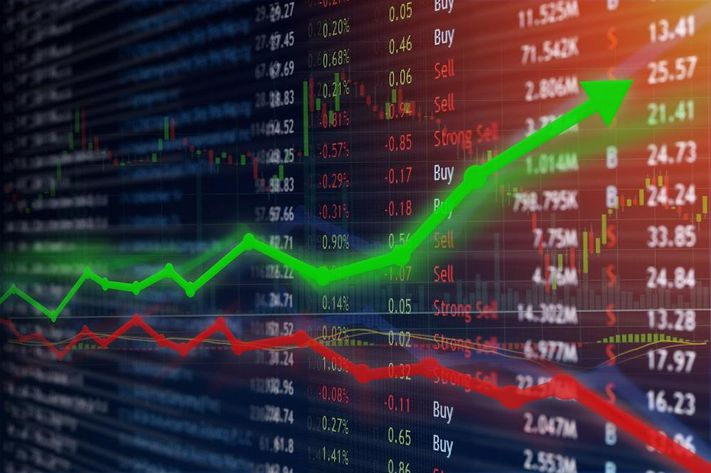

## Introduction:

One might wish that the time machine in the movie "Back To The Future" really existed! Stock price prediction would have been more accurate. However, no one can predict the future!

## Objective:

Explain in detail the procedures used to predict Amazon stock prices for the next 7 days using LSTM networks with TensorFlow.

## Why LSTM?

The picture below shows the cell structures of Long Short-Term Memory (LSTM) and Recurrent Neural Network (RNN). LSTM, which is a special type of RNN, consists of an input gate, a forget gate and an output gate. These cells can maintain information in memory for a long period of time. This ability is perfect for predicting stock prices since it can store past information and learn its pattern.

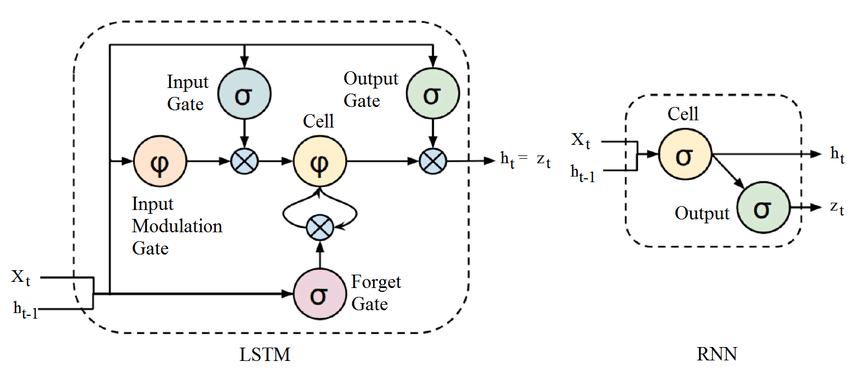

## Lets Start!

## Import Libraries

In [1]:
# Import Python libraries

import pandas as pd # for data wrangling
import numpy as np # for numerical computation
import matplotlib.pyplot as plt # import plotting package
import matplotlib as mpl # additional plotting functionality 

# Render plotting automatically
%matplotlib inline 

from sklearn.preprocessing import MinMaxScaler # to scale numerical values between 0 and 1
plt.style.use('seaborn-darkgrid') # plotting style

# Import Neural Network library

from tensorflow.keras.models import Sequential # to create a model, layer by layer
from tensorflow.keras.layers import LSTM, Dense # to add layers in model formation
from tensorflow.keras.optimizers import Adam # a type of optimization

## Read the Data

In [2]:
# Use Pandas to load and read data in tabular form. 
# Data was downloaded from the Yahoo Finance website.
# Look at the last 5 rows of the dataframe. 
# Here we can see that there are 5031 rows altogether.
# The latest date recorded was July 31st, 2020

df = pd.read_csv('AMZN_20.csv') 
df.tail()  

,Date,Open,High,Low,Close,Adj Close,Volume
5027,2020-07-27,3062.00000,3098.000000,3015.77002,3055.209961,3055.209961,4170500
5028,2020-07-28,3054.27002,3077.090088,2995.76001,3000.330078,3000.330078,3126700
5029,2020-07-29,3030.98999,3039.159912,2996.77002,3033.530029,3033.530029,2974100
5030,2020-07-30,3014.00000,3092.000000,3005.00000,3051.879883,3051.879883,6128300
5031,2020-07-31,3244.00000,3246.820068,3151.00000,3164.679932,3164.679932,8085500


## Data Quality Check & Preprocessing

In [3]:
# There are 7 columns and 5032 rows.
# There are 2 data types associated with this dataframe: float64(number with decimal) and int64(whole number).
# Date is misclassified as object(string). Changes need to be done.
# The rest of the data looks good.
# There are no null values.

df.info() # gives information about the dataframe

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5032 entries, 0 to 5031
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5032 non-null   object 
 1   Open       5032 non-null   float64
 2   High       5032 non-null   float64
 3   Low        5032 non-null   float64
 4   Close      5032 non-null   float64
 5   Adj Close  5032 non-null   float64
 6   Volume     5032 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 275.3+ KB


In [4]:
# Set date as an index column and choose the "Close" column for prediction.
# Only 1 feature is used to predict the prices at the moment. 
# More features can be added later on to improve the model's accuracy.
# Use the last 500 days (recent) for a more accurate prediction.

df = df.set_index('Date')[['Close']].tail(500)

In [5]:
# Set date data type to "datetime". 

df = df.set_index(pd.to_datetime(df.index))
df.head()

,Close
Date,
2018-08-07,1862.479980
2018-08-08,1886.520020
2018-08-09,1898.520020
2018-08-10,1886.300049
2018-08-13,1896.199951


In [6]:
# Check the updated version of the dataframe.

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500 entries, 2018-08-07 to 2020-07-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   500 non-null    float64
dtypes: float64(1)
memory usage: 7.8 KB


In [7]:
# Check the mean and standard deviation of the last 500 closing prices.
# The mean of the closing prices is $ 1937.
# The standard deviation of the closing prices is $346.
# The maximum (max) and minimum (min) values are $3200 and $1344 respectively.
# 25%, 50% and 75% show the lower percentile, median and upper percentile of the 
# prices respectively.

df.describe()

,Close
count,500.000000
mean,1937.435061
std,345.745602
min,1343.959961
25%,1752.725036
50%,1847.109985
75%,1973.009979
max,3200.000000


In [8]:
# Instantiate scaler.
# Use scaler to scale down prices between 0 and 1. This allows for more accurate analysis.
# Create a dataframe object to fit and then transform datasets.
# .head() shows the first 5 rows of the dataframe, with date as the index column and "Close" as the only column.

scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df.head() 

,Close
Date,
2018-08-07,0.279369
2018-08-08,0.292321
2018-08-09,0.298787
2018-08-10,0.292203
2018-08-13,0.297537


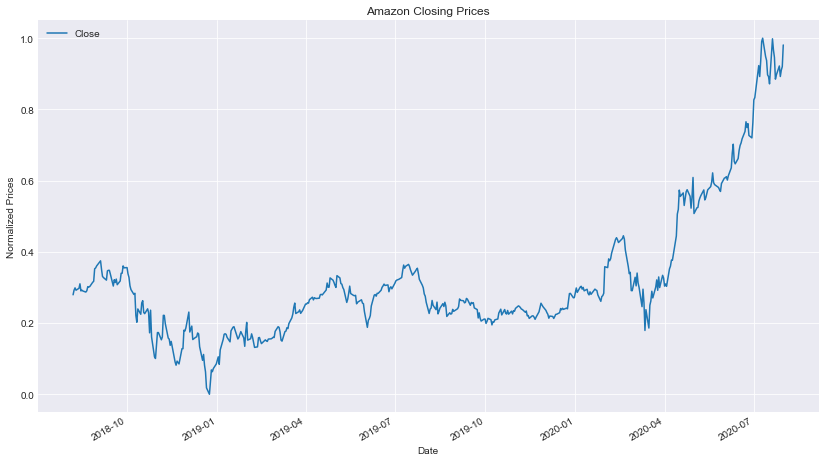

In [9]:
# Plot closing prices over dates.
# The plot shows normalized prices.
# We can now see an increasing pattern over time.
# A noticeable spike can be seen starting in April 2020. 

df.plot(figsize=(14,8))
plt.title('Amazon Closing Prices')
plt.ylabel('Normalized Prices')
plt.show()

## Helper Functions

In [10]:
# split_sequence splits the datasets into training and test sets.
# n_steps_ in = the number of inputs and n_steps_ out = the number of outputs.
# In this case, n_steps_out = 7.
# The term "break" is used to stop the loop in case the number of sequence exceeds the maximum length.
# .append is used to add values into the list.
# At the end, the function returns numpy arrays of values X (past closing prices) and y (future prices).


def split_sequence(seq, n_steps_in, n_steps_out):
    X,y = [],[]

    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [11]:
#  visualize_results functions helps visualize the neural network created.

def visualize_results(results):
    history = results.history
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'], label='test')
    plt.plot(history['loss'], label='train')
    plt.legend(['test', 'train'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
   
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'], label='test')
    plt.plot(history['accuracy'], label = 'train')
    plt.legend(['test', 'train'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

## Split Data

In [12]:
# Use the split_sequence function from the helper functions above to split the dataset.
# Use the values from the last 30 days (n_per_in) to predict prices for the next 7 days(n_per_out).
# Input X is reshaped into a 3 dimensional format. This is a requirement for use with LSTM.
# The format is [samples, timesteps, features].
# The inputs shape: 464 samples, 30 timesteps and 1 feature. 
# Reshaping data to the correct size is important in order for the code to work.

n_per_in = 30
n_per_out = 7

n_features = 1 

X,y = split_sequence(list(df.Close), n_per_in, n_per_out)

print(X.shape)

X = X.reshape(X.shape[0], X.shape[1], n_features)

print(X.shape)

(464, 30)
(464, 30, 1)


## Construct Neural Network - Fit Model

In [13]:
# Instantiate the model.
# Define LSTM with 30 neurons in the first hidden layer and 7 neurons in the output layer
# for the next 7 days of price prediction.

model = Sequential()

model.add(LSTM(30, activation='softsign', return_sequences=True, 
               input_shape=(n_per_in, n_features)))
model.add(LSTM(20, activation='softsign', return_sequences=True))
model.add(LSTM(20, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign', return_sequences=True))
model.add(LSTM(10, activation='softsign'))

model.add(Dense(n_per_out))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 30)            3840      
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 20)            4080      
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 20)            3280      
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 10)            1240      
_________________________________________________________________
lstm_4 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 10)            840       
_________________________________________________________________
lstm_6 (LSTM)                (None, 10)                8

In [14]:
# Compile the model.
# The mean squared error is used as a loss function.
# Use the Adam algorithm as an optimizer.

opt = Adam(lr = 0.00001)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [15]:
# Train the model.
# The model is fitted using 150 training epochs with a batch size of 30.
# The amount of epochs depends on whether cpu/gpu-hardware is used. More time is needed to
# train the model with CPU. 
# Epoch = the amount of time the entire dataset is passed forward and backward through 
# the neural network. In this case 150 times!
# 1 epoch is too big to feed to the computer at once so, it is divided into several batches.
# Batch size = the number of taining data in one batch.
# Validation_split = the percentage of the training data held back to 
# validate performance. In this case, 10 %.

result = model.fit(X,y, epochs=150, batch_size=30, validation_split=0.1)

Epoch 1/150
14/14 [==============================] - 2s 115ms/step - loss: 0.0687 - accuracy: 0.1007 - val_loss: 0.5155 - val_accuracy: 0.1064
Epoch 2/150
14/14 [==============================] - 1s 57ms/step - loss: 0.0398 - accuracy: 0.1199 - val_loss: 0.3866 - val_accuracy: 0.1064
Epoch 3/150
14/14 [==============================] - 1s 58ms/step - loss: 0.0199 - accuracy: 0.1199 - val_loss: 0.2837 - val_accuracy: 0.1064
Epoch 4/150
14/14 [==============================] - 1s 57ms/step - loss: 0.0143 - accuracy: 0.1199 - val_loss: 0.2833 - val_accuracy: 0.1064
Epoch 5/150
14/14 [==============================] - 1s 54ms/step - loss: 0.0119 - accuracy: 0.1199 - val_loss: 0.2784 - val_accuracy: 0.1064
Epoch 6/150
14/14 [==============================] - 1s 58ms/step - loss: 0.0112 - accuracy: 0.1031 - val_loss: 0.2714 - val_accuracy: 0.0851
Epoch 7/150
14/14 [==============================] - 1s 59ms/step - loss: 0.0112 - accuracy: 0.0935 - val_loss: 0.2704 - val_accuracy: 0.0851
Epoch

## Loss & Accuracy Visualization

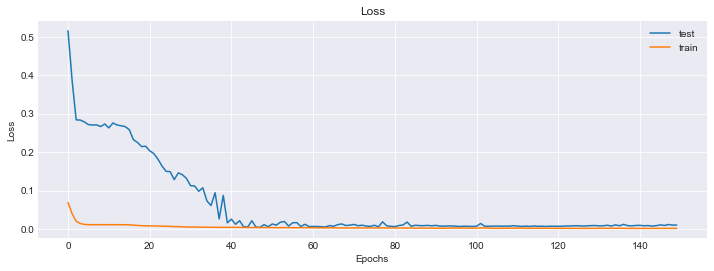

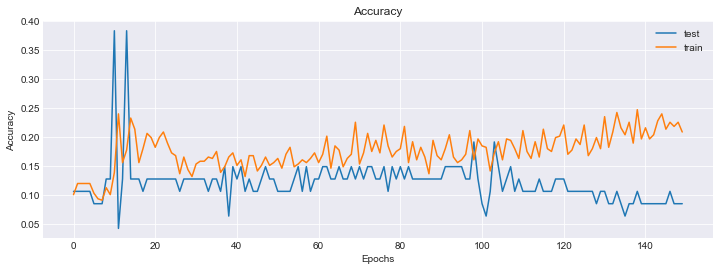

In [16]:
# The loss and accuracy pattern during training is displayed below.
# The plot shows that the training loss drops below the test loss and eventually converge at 40 epochs and onwards.
# The accuracy plot shows that both training and test values start to diverge at around 100 epochs.
# This can be a sign of underfitting or overfitting. 

visualize_results(result)

## Model Validation

predicted [[3124.986060306744], [3089.5347912393577], [3110.070779596399], [3071.7188284478743], [3127.0200778789717], [3154.3241031681205], [3127.964293041539]]
actuals [[2986.550049], [3008.909912], [3055.209961], [3000.330078], [3033.530029], [3051.8798829999996], [3164.679932]]


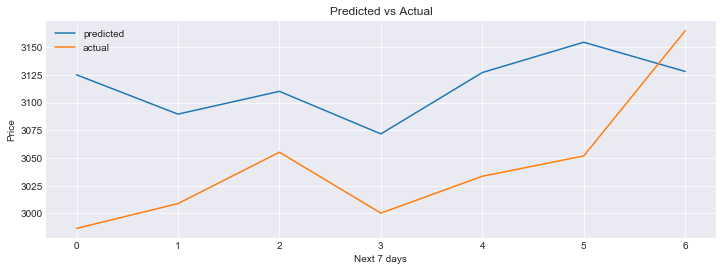

In [17]:
# The code used to predict prices is shown below.
# A comparison is shown between prediction and actual values.
# Both values converge between the 5th and 6th day.

plt.figure(figsize=(12,4))

yhat = model.predict(X[-1].reshape(1, n_per_in, n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

actual = scaler.inverse_transform(y[-1].reshape(-1,1)).tolist()

print('predicted', yhat)
plt.plot(yhat, label='predicted')

print('actuals', actual)
plt.plot(actual, label='actual')

plt.title('Predicted vs Actual')
plt.ylabel('Price')
plt.xlabel('Next 7 days')
plt.legend()
plt.show()

## Future Prediction

                  Close
2020-07-31  3170.251414
2020-08-01  3134.530986
2020-08-02  3152.648080
2020-08-03  3112.617561
2020-08-04  3166.309164
2020-08-05  3197.697266
2020-08-06  3172.451928


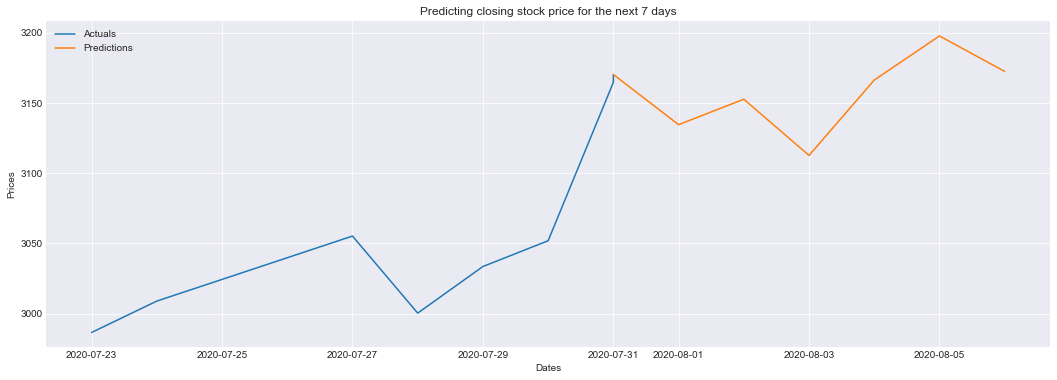

In [18]:
# The code used to predict the closing prices for the next 7 days is shown below.
# inverse_transform is used to transform the normalized values back to the original values.

yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1,n_per_in, n_features)).tolist()[0]
yhat = scaler.inverse_transform(np.array(yhat).reshape(-1,1)).tolist()

# The "preds" table predicts the next 7 days starting with the last date downloaded in the dataset. 
# The frequency 'D' is equivalent to 'day'.

preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat),
        freq='D'),columns=df.columns)
print(preds)
periods = 7

# The inverse_transform method transforms the last 7 days of normalized prices back to the original form. 

actual = pd.DataFrame(scaler.inverse_transform(df[['Close']].tail(periods)), 
        index = df.Close.tail(periods).index, columns= df.columns).append(preds.head(1))

plt.figure(figsize=(18,6))
plt.plot(actual, label='Actuals')
plt.plot(preds, label='Predictions')
plt.title(f'Predicting closing stock price for the next {len(yhat)} days')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()
plt.show()

## Conclusion

The machine learning model predicts an increase in stock prices. From the prediction above, we see that LSTM networks are able to predict future stock prices. According to Forbes.com, despite the Coronavirus pandemic, Amazon has benefited millions since people turned to online marketplaces for essential requirements. 

## Improvement

#### Below are steps that were taken to optimize the model perfomance:

1. Used different scalers: RobustScaler, MinMaxScaler
2. Changed the learning rate : 0.1, 0.01, 0.001, 0.0001, 0.00001
3. Doubled the amount of datasets downloaded from Yahoo finance website
4. Changed the amount of the most recent datasets : 1000, 800, 500, 250
5. Used different loss functions: MSE, RMSE, MAE
6. Tweaked network size layers : between 3-8 layers
7. Tweaked network size neurons : 60-20 
8. Used different optimizers: SGD, Adam
9. Used different activation functions : ReLu, Sigmoid, Tanh

#### Steps for future improvement: 

1. Try the 9 steps above again using different combinations.
2. Check out multiple input features instead of one input feature only.
3. Learn more techniques and improve by reading literature on this topic.